# 디자인 유사성 분석 챗봇

## 기능
1. **이미지 → 유사 디자인 10개 검색** (CLIP + ChromaDB)
2. **사용자가 1개 선택 → 상세 비교 분석** (interrupt + VLM)
3. **최종 리포트 생성** (LLM)
4. **일반 질문 + 웹 검색 + DB 검색** (Tool)

## 그래프 구조 (2갈래)
```
[입력] → [라우터]
  ├─ image ─→ [VLM분석] → [벡터검색] → ★interrupt(선택대기)★ → [상세비교] → [리포트] → END
  └─ text  ─→ [LLM + Tools(웹검색, DB검색)] → END
```

## 1. 환경 설정 & 임포트

In [ ]:
import os
import json
import base64
from typing import TypedDict, List, Dict, Any

# LangChain & LangGraph
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.types import interrupt, Command  # interrupt: 사용자 개입 기능
from langgraph.checkpoint.memory import MemorySaver  # interrupt 사용시 필수
from langgraph.prebuilt import ToolNode

# 웹 검색
from langchain_community.tools import TavilySearchResults

# 벡터DB
import chromadb

# 기존 유틸 함수 재사용
from utils import (
    get_image_embedding,              # 이미지 → CLIP 임베딩
    get_text_embedding,               # 텍스트 → CLIP 임베딩 (DB검색 Tool용)
    design_id_to_local_image,         # design_id → 로컬 이미지 경로
    search_and_filter_similar_designs # 벡터DB 검색 + 중복 필터링
)

# 기존 프롬프트 재사용
from prompts import (
    IMAGE_ANALYSIS_PROMPT,    # 이미지 형상 분석
    IMAGE_COMPARISON_PROMPT,  # 두 이미지 비교
    REPORT_PROMPT # 최종 리포트 생성
)

from dotenv import load_dotenv
load_dotenv()

print("임포트 완료!")

c:\Users\playdata2\miniconda3\envs\langchain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


프롬프트 정의 완료!
임포트 완료!


In [ ]:
# LLM 로드
llm = ChatOpenAI(model="gpt-4o", temperature=0)
output_parser = StrOutputParser()

print("LLM 로드 완료!: GPT-4o")

# ChromaDB 로드
chroma_client = chromadb.PersistentClient(path="design\\chroma_db")
image_collection = chroma_client.get_collection(name="design")

print(f"ChromaDB 로드 완료: {image_collection.count()}개 디자인")

LLM 로드 완료!: GPT-4o
ChromaDB 로드 완료: 21829개 디자인


## 2. State 정의

State = 노드 간에 주고받는 데이터 구조(스키마)

- 모든 노드가 같은 state 딕셔너리를 받아서 읽고/업뎃,수정하고/다음 노드로 넘김
- GraphState로 딕셔너리의 키와 타입을 정의


In [3]:
class GraphState(TypedDict):
    """그래프 전체에서 공유되는 상태"""
    
    #입력 관련 필드 
    input_type: str          # "image" | "text"
    image_path: str          # 사용자가 입력한 이미지 경로
    text_query: str          # 텍스트 질문
    user_query: str          # 사용자 질문
    base64_image: str        # base64 인코딩된 입력 이미지
    
    # 이미지 검색&분석 관련 필드
    input_analysis: str              # VLM 분석 결과
    search_results: Dict[str, Any]   # 벡터DB 검색 원본
    comparison_results: List[Dict]   # 검색 원본을 깔끔하게 정리 -> 최종 유사 디자인 목록 
    selected_index: int              # 사용자가 선택한 디자인 번호
    detailed_comparison: str         # 선택한 디자인 vlm 상세 비교 결과
    final_report: str                # 최종 리포트
    
    # 텍스트 관련 필드
    general_answer: str              # 일반 질문 답변

print("State 정의 완료!")

State 정의 완료!


## 3. Tool 정의 (웹 검색 + DB 검색)

In [4]:
# Tool 1: 웹 검색 (TAVILY_API_KEY 필요!)
@tool
def web_search(query: str) -> str:
    """웹 검색 tool. 특허 뉴스, 법률 정보, 일반 질문 등에 활용됨."""
    search = TavilySearchResults(max_results=3) # n =3 
    results = search.invoke(query)

    # 결과 정리
    output = ""
    for r in results:
        output += f"- {r['content']}\n  출처: {r['url']}\n\n"
    return output


# Tool 2: 디자인 DB 검색 (텍스트 → CLIP 임베딩 → ChromaDB)
@tool
def search_design_db(query: str) -> str:
    """사용자가 자연어로 유사 디자인을 검색할 경우 사용되는 tool. 
      예: 둥근 펌프 용기, 사각형 병"""
    
    # 텍스트 → CLIP 임베딩 
    embedding, translated = get_text_embedding(query, translate_korean=True)
    if embedding is None:
        return "임베딩 생성 실패"
    
    # 벡터DB 검색
    results = search_and_filter_similar_designs(image_collection, embedding, n_results=5)
    
    # 결과 정리
    output = f"'{query}' 검색 결과 (번역: '{translated}'):\n\n"
    for i in range(len(results['ids'][0])):
        meta = results['metadatas'][0][i]
        dist = results['distances'][0][i]
        output += (
            f"{i+1}. {meta.get('articleName', 'N/A')}\n"
            f"   출원번호: {meta.get('applicationNumber', 'N/A')}\n"
            f"   등록상태: {meta.get('admstStat', 'N/A')}\n"
            f"   유사도 거리: {dist:.4f}\n\n"
        )
    return output

In [11]:
# Tool 목록 & LLM 바인딩
tools = [web_search, search_design_db] 
llm_with_tools = llm.bind_tools(tools)

print("Tool 정의 완료! (web_search, search_design_db)")

Tool 정의 완료! (web_search, search_design_db)


## 5. 노드 함수 정의

In [12]:
# ===== 노드 0: router (2갈래: image / text) =====

def router_node(state: GraphState) -> GraphState:
    """입력 타입 판단: 이미지가 있으면 image, 아니면 text"""

    if state.get('image_path') and os.path.exists(state['image_path']):
        state['input_type'] = 'image'
        print("[router] 이미지 입력 → 유사 디자인 검색 경로로 라우팅합니다. ")
    else:
        state['input_type'] = 'text'
        print("[router] 텍스트 입력 → LLM + Tools 경로로 라우팅합니다. ")
    return state


def route_by_type(state: GraphState) -> str:
    """라우터 분기: 'image' 또는 'text'"""
    return state['input_type'] 

print("라우터 정의 완료!")

라우터 정의 완료!


In [14]:
# ===== 이미지 경로: VLM 분석 + 벡터 검색 =====

def analyze_image_node(state: GraphState) -> GraphState:
    """이미지를 VLM(GPT-4O)으로 형상 분석"""
    print("[VLM분석] 입력 이미지 분석 중 ~")
    
    # 이미지 → base64
    with open(state['image_path'], "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    url = f"data:image/jpeg;base64,{b64}"
    
    # VLM 분석 (IMAGE_ANALYSIS_PROMPT 사용)
    chain = IMAGE_ANALYSIS_PROMPT | llm | output_parser 
    analysis = chain.invoke({"image_url": url}) 
    
    # 상태 update 
    state['base64_image'] = url
    state['input_analysis'] = analysis
    print(f"  분석 완료 ({len(analysis)}자)")
    return state


def image_search_node(state: GraphState) -> GraphState:
    """입력 이미지로 벡터DB에서 유사 디자인 10개 검색"""
    print("[벡터검색] 유사 디자인 검색 중...")
    
    # CLIP 임베딩 → 벡터DB 검색
    embedding = get_image_embedding(state['image_path']) 
    results = search_and_filter_similar_designs(image_collection, embedding, n_results=10) 
    state['search_results'] = results #검색 원본 저장
    
    # 원본 결과를 사용자에게 보여줄 포맷으로 정리 (인덱스, 디자인id, 거리, 출원번호, 상품명, 등록상태, 이미지 경로)
    comparison_results = []
    for i in range(len(results['ids'][0])):
        design_id = results['ids'][0][i]
        metadata = results['metadatas'][0][i]
        distance = results['distances'][0][i]
        
        comparison_results.append({
            'index': i + 1,
            'design_id': design_id,
            'distance': distance,
            'application_number': metadata.get('applicationNumber', 'N/A'),
            'article_name': metadata.get('articleName', 'N/A'),
            'admst_stat': metadata.get('admstStat', 'N/A'),
            'image_path': design_id_to_local_image(design_id),
        })
    
    state['comparison_results'] = comparison_results # 최종 유사 디자인 목록 저장 
    print(f"  {len(comparison_results)}개 유사 디자인 발견")
    return state

print("이미지 경로 노드 정의 완료!")

이미지 경로 노드 정의 완료!


In [15]:
# ===== interrupt: 사용자 선택 대기 =====

def show_results_node(state: GraphState) -> GraphState:
    """검색 결과 10개를 보여주고, 사용자 선택을 기다림 (interrupt)"""
    print("\n" + "="*50)
    print("유사 디자인 검색 결과")
    print("="*50)
    
    for comp in state['comparison_results']:
        print(f"  [{comp['index']}] 출원번호: {comp['application_number']}",
              f"상품명: {comp['article_name']}, "
              f"등록상태: {comp['admst_stat']}, "
              f"거리: {comp['distance']:.4f}")
        

    # ★ interrupt: 여기서 그래프 실행이 멈추고, 사용자 입력을 기다림 ★
    selected = interrupt({
        "message": "상세 비교할 디자인 번호를 선택하세요! VLM이 선택한 디자인과 입력 디자인을 비교 분석해, 자세한 유사점/차이점을 알려드립니다.",
        "options": [comp['index'] for comp in state['comparison_results']]
    })
    
    state['selected_index'] = int(selected) # 선택된 디자인 번호 저장

    print(f"\n  → {selected}번 디자인 선택됨!")
    return state

print("interrupt 노드 정의 완료!")

interrupt 노드 정의 완료!


In [16]:
# ===== 상세 비교 & 리포트 =====

def detailed_compare_node(state: GraphState) -> GraphState:
    """선택한 디자인 1개와 입력 디자인을 VLM 상세 비교"""

    print("[상세비교] 분석 중...")
    
    # comparison_results에서 선택한 디자인 찾기
    selected = next(
        (c for c in state['comparison_results'] if c['index'] == state['selected_index']),
        None
    )
    
    # 만약 선택한 디자인 번호가 존재하지 않거나,이미지 경로/파일이 없을시 오류 메시지 저장 후 종료
    if not selected or not selected['image_path'] or not os.path.exists(selected['image_path']):
        state['detailed_comparison'] = "비교 대상 이미지를 찾을 수 없습니다."
        return state
    
    # 비교 대상 이미지 → base64
    with open(selected['image_path'], "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    comp_url = f"data:image/jpeg;base64,{b64}"
    
    # 두 이미지 VLM 비교 (IMAGE_COMPARISON_PROMPT 사용)
    chain = IMAGE_COMPARISON_PROMPT | llm | output_parser
    result = chain.invoke({
        "input_image_url": state['base64_image'], # 입력 이미지
        "comparison_image_url": comp_url # 비교 대상 이미지
    })
    
    state['detailed_comparison'] = result # 비교 결과 state 저장

    print("  상세 비교 완료!")
    return state


def generate_report_node(state: GraphState) -> GraphState:
    """상세 비교 결과로 FTO 리포트 생성"""
    print("[리포트] 생성 중...")
    
    # comparison_results에서 선택한 디자인 정보 찾기
    selected = next(
        (c for c in state['comparison_results'] if c['index'] == state['selected_index']),
        None
    )
    
    design_info = "정보 없음"
    if selected:
        design_info = (
            f"출원번호: {selected['application_number']}\n"
            f"상품명: {selected['article_name']}\n"
            f"등록상태: {selected['admst_stat']}\n"
            f"유사도 거리: {selected['distance']:.4f}"
        )
    
    # 리포트 생성
    chain = REPORT_PROMPT | llm | output_parser
    report = chain.invoke({
        "input_analysis": state.get('input_analysis', ''), # 입력 이미지 분석 결과
        "detailed_comparison": state.get('detailed_comparison', ''), # VLM 상세 비교 결과
        "selected_design_info": design_info, # 비교대상 디자인 정보
        "user_query": state.get('user_query', 'FTO 리포트를 작성해줘') # 사용자 요청
    })
    
    state['final_report'] = report
    print(f"  리포트 완료 ({len(report)}자)")
    return state

print("상세비교 + 리포트 노드 정의 완료!")

상세비교 + 리포트 노드 정의 완료!


In [20]:
# ===== 텍스트 경로: 일반 질문 (LLM + Tools) =====

def general_question_node(state: GraphState) -> GraphState:
    """LLM이 필요에 따라 web_search, search_design_db Tool을 사용하여 답변"""

    print("[일반질문] 답변 생성 중...")
    
    # 어떤 tool이 필요한지 판단하기 위해 llm에게 전달하는 프롬포트 (system에 tool 사용 지침 포함)
    messages = [
        {"role": "system", "content": (
            "당신은 디자인 특허 전문 어시스턴트입니다.\n"
            "- 디자인 검색이 필요하면 search_design_db 도구를 사용하세요.\n"
            "- 최신 정보, 웹 검색이 필요하면 web_search 도구를 사용하세요.\n"
            "- 답변은 친절하고 정확하게."
        )},
        {"role": "user", "content": state['text_query']}
    ]
    
    # llm이 질문을 보고 tool을 쓸지 말지 스스로 판단 -> tool_calls(도구 호출 요청) 포함된 response 반환
    response = llm_with_tools.invoke(messages)
    
    if response.tool_calls:
        # Tool 호출 있는 경우 

        for tc in response.tool_calls:
            print(f"  Tool 호출: {tc['name']}({tc['args']})")
        

        #toolNode가 LLM이 요청한 Tool(web_search 또는 search_design_db)을 대신 실행
        tool_node = ToolNode(tools) # ToolNode 생성
        tool_results = tool_node.invoke({"messages": [response]}) # Tool 실행
        
 
        messages.append(response) 

        for msg in tool_results['messages']:
            #messages에 tool 실행결과 포함
            messages.append(msg)
        
        # 최종 응답 생성
        final = llm.invoke(messages)
        state['general_answer'] = final.content
        
    else:
        # Tool 없이 직접 답변
        state['general_answer'] = response.content
    
    print("  답변 완료")
    return state

print("일반질문 노드 정의 완료!")

일반질문 노드 정의 완료!


## 6. 그래프 조립

In [21]:
def create_graph():
    """
    그래프 생성 (2갈래)
    
    image: 라우터 → VLM분석 → 벡터DB검색 → interrupt → 상세비교 → 리포트 → END
    text:  라우터 → 일반질문(+Tools) → END
    """
    workflow = StateGraph(GraphState)
    
    # 노드 등록 (6개)
    # add_node(노드명, 함수)
    workflow.add_node("router", router_node)
    workflow.add_node("analyze_image", analyze_image_node)
    workflow.add_node("image_search", image_search_node)
    workflow.add_node("show_results_and_interrupt", show_results_node)       # interrupt 포함
    workflow.add_node("detailed_compare", detailed_compare_node)
    workflow.add_node("generate_report", generate_report_node)
    workflow.add_node("general_question", general_question_node)
    
    # 시작점
    workflow.set_entry_point("router")
    

    # 엣지 추가 
    # 라우터 → 2갈래 분기
    workflow.add_conditional_edges(  # 조건부 분기
        "router",
        route_by_type,
        {
            'image': 'analyze_image',       # 이미지면 → VLM 분석
            'text': 'general_question'      # 텍스트면 → LLM + Tools
        }
    )
    
    # 이미지 경로
    workflow.add_edge("analyze_image", "image_search")
    workflow.add_edge("image_search", "show_results_and_interrupt")
    workflow.add_edge("show_results_and_interrupt", "detailed_compare")
    workflow.add_edge("detailed_compare", "generate_report")
    workflow.add_edge("generate_report", END)
    
    # 텍스트 경로
    workflow.add_edge("general_question", END)
    
    # 컴파일 (MemorySaver: interrupt에 필수)
    graph = workflow.compile(checkpointer=MemorySaver())
    return graph


graph = create_graph()
print("그래프 생성 완료! (노드 7개, 분기 2갈래)")

그래프 생성 완료! (노드 7개, 분기 2갈래)


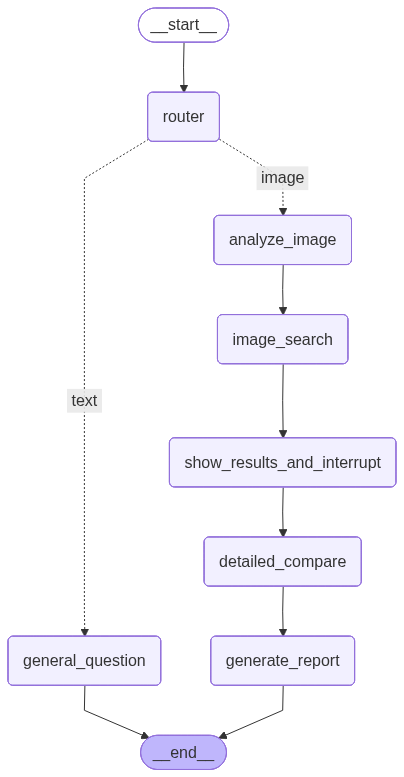

In [22]:
# 그래프 시각화
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"시각화 불가: {e}")
    print("\n그래프 구조:")
    print("  image: router → analyze_image → image_search → show_results(interrupt) → detailed_compare → generate_report → END")
    print("  text:  router → general_question(+Tools) → END")

## 7. 실행 함수

In [23]:
def run_chatbot(image_path=None, text_query=None, user_query="이 제품과 유사한 디자인을 분석해줘"):
    """
    챗봇 실행
    
    이미지 검색:  run_chatbot(image_path="path/to/image.jpg")
    일반 질문:    run_chatbot(text_query="디자인 특허란?")
    DB 검색:     run_chatbot(text_query="펌프형 용기 디자인 찾아줘")
    웹 검색:     run_chatbot(text_query="2024년 디자인 특허 트렌드")
    """
    # 초기 상태
    initial_state = {
        "input_type": "",
        "image_path": image_path or "",
        "text_query": text_query or "",
        "user_query": user_query,
        "base64_image": "",
        "input_analysis": "",
        "search_results": {},
        "comparison_results": [],
        "selected_index": 0,
        "detailed_comparison": "",
        "final_report": "",
        "general_answer": "",
    }
    
    config = {"configurable": {"thread_id": "session-1"}}
    
    print("\n" + "="*60)
    print("디자인 유사성 분석 챗봇 v3")
    print("="*60)
    
    # 1단계: 그래프 실행 (이미지면 interrupt에서 멈춤)
    result = graph.invoke(initial_state, config)
    
    # 텍스트 경로면 바로 답변 출력 후 종료
    if result.get('general_answer'):
        print("\n" + "="*60)
        print(result['general_answer'])
        print("="*60)
        return result
    
    # 2단계: 이미지 경로 → interrupt에서 멈춤 → 사용자 선택
    user_choice = input("\n번호 입력 > ")
    
    # 3단계: 선택값으로 그래프 재개
    result = graph.invoke(Command(resume=user_choice), config)
    
    # 리포트 출력
    print("\n" + "="*60)
    print("최종 FTO 리포트")
    print("="*60)
    print(result.get('final_report', '리포트 생성 실패'))
    
    return result

print("실행 함수 정의 완료!")

실행 함수 정의 완료!


## 8. 테스트

In [25]:
# 테스트 1: 이미지 → 유사 10개 → 선택 → 상세비교 → 리포트
image_path = r"C:\Users\playdata2\Desktop\SKN_AI_20\SKN20-FINAL-2TEAM(vb2)\design\data\images_v2\3019810003379-api_xml-1_001.JPG"
result = run_chatbot(image_path=image_path)


디자인 유사성 분석 챗봇 v3
[router] 이미지 입력 → 유사 디자인 검색 경로로 라우팅합니다. 
[VLM분석] 입력 이미지 분석 중 ~
  분석 완료 (211자)
[벡터검색] 유사 디자인 검색 중...
  8개 유사 디자인 발견

유사 디자인 검색 결과
  [1] 출원번호: 3019810003379 상품명: 전등갓, 등록상태: 공개, 거리: 0.0005
  [2] 출원번호: 3020240009248 상품명: 분무 용기, 등록상태: 등록, 거리: 0.0521
  [3] 출원번호: 3020100053835 상품명: 스포이드를 가진 화장품 용기, 등록상태: 등록, 거리: 0.0555
  [4] 출원번호: 3020230002405 상품명: 인체용 케어용품 용기 몸체, 등록상태: 등록, 거리: 0.0558
  [5] 출원번호: 3020190042869 상품명: 유아용 세정제 용기, 등록상태: 등록, 거리: 0.0572
  [6] 출원번호: 3020210046493 상품명: 화장품 포장용기 몸체, 등록상태: 등록, 거리: 0.0580
  [7] 출원번호: 3020140002033 상품명: 향수 용기, 등록상태: 등록, 거리: 0.0585
  [8] 출원번호: 3020250031566 상품명: 화장품용 용기, 등록상태: 등록, 거리: 0.0608

유사 디자인 검색 결과
  [1] 출원번호: 3019810003379 상품명: 전등갓, 등록상태: 공개, 거리: 0.0005
  [2] 출원번호: 3020240009248 상품명: 분무 용기, 등록상태: 등록, 거리: 0.0521
  [3] 출원번호: 3020100053835 상품명: 스포이드를 가진 화장품 용기, 등록상태: 등록, 거리: 0.0555
  [4] 출원번호: 3020230002405 상품명: 인체용 케어용품 용기 몸체, 등록상태: 등록, 거리: 0.0558
  [5] 출원번호: 3020190042869 상품명: 유아용 세정제 용기, 등록상태: 등록, 거리: 0.0572
  [6] 출원번호: 30202100

In [26]:
# 테스트 2: 일반 질문 (LLM이 알아서 Tool 사용 여부 결정)
result = run_chatbot(text_query="디자인 특허 출원 절차가 뭐야?")


디자인 유사성 분석 챗봇 v3
[router] 텍스트 입력 → LLM + Tools 경로로 라우팅합니다. 
[일반질문] 답변 생성 중...
  답변 완료

디자인 특허 출원 절차는 일반적으로 다음과 같은 단계로 이루어집니다:

1. **디자인 준비**: 보호받고자 하는 디자인을 명확히 정의하고, 도면이나 사진 등으로 시각적으로 표현합니다.

2. **선행 디자인 조사**: 기존에 유사한 디자인이 등록되어 있는지 조사합니다. 이를 통해 디자인의 신규성과 독창성을 확인할 수 있습니다.

3. **출원서 작성**: 디자인의 상세한 설명과 도면을 포함한 출원서를 작성합니다. 이때, 디자인의 특징과 차별점을 명확히 기술해야 합니다.

4. **출원서 제출**: 해당 국가의 특허청에 출원서를 제출합니다. 온라인으로 제출할 수 있는 경우도 많습니다.

5. **심사**: 특허청에서 출원된 디자인을 심사합니다. 이 과정에서 디자인의 신규성, 독창성, 산업적 이용 가능성 등을 평가합니다.

6. **등록 결정**: 심사 결과에 따라 디자인이 등록될 수 있습니다. 등록이 결정되면 등록료를 납부해야 합니다.

7. **디자인 등록**: 등록이 완료되면 디자인권이 부여되며, 이를 통해 법적 보호를 받을 수 있습니다.

8. **유지 및 관리**: 디자인권을 유지하기 위해 정기적으로 갱신료를 납부해야 합니다.

각국의 특허청마다 절차나 요구사항이 다를 수 있으므로, 출원하고자 하는 국가의 특허청 가이드를 참고하는 것이 중요합니다.


In [27]:
# 테스트 3: DB 검색 (LLM이 search_design_db Tool 호출)
result = run_chatbot(text_query="펌프형 용기 디자인 찾아줘")


디자인 유사성 분석 챗봇 v3
[router] 텍스트 입력 → LLM + Tools 경로로 라우팅합니다. 
[일반질문] 답변 생성 중...
  Tool 호출: search_design_db({'query': '펌프형 용기'})
   한글 감지: '펌프형 용기' → 영어로 번역 중...
   ✅ 번역 완료: 'Pump container'
  답변 완료

다음은 '펌프형 용기'와 관련된 디자인 특허 목록입니다:

1. **약액용기**
   - 출원번호: 3020210009978
   - 등록상태: 등록

2. **포장용 병 (BOTTLE)**
   - 출원번호: 3020150010170
   - 등록상태: 등록

3. **화장품 포장용기**
   - 출원번호: 3020130056004
   - 등록상태: 등록

4. **화장품 용기용 몸체**
   - 출원번호: 3020220034721
   - 등록상태: 등록

5. **화장품 용기**
   - 출원번호: 3020170023973
   - 등록상태: 등록

이 디자인들은 모두 등록된 상태입니다. 추가적인 정보가 필요하시면 말씀해 주세요!


In [28]:
# 테스트 4: 웹 검색 (LLM이 web_search Tool 호출)
result = run_chatbot(text_query="2024년 디자인 특허 출원 통계 알려줘")


디자인 유사성 분석 챗봇 v3
[router] 텍스트 입력 → LLM + Tools 경로로 라우팅합니다. 
[일반질문] 답변 생성 중...
  Tool 호출: web_search({'query': '2024년 디자인 특허 출원 통계'})


C:\Users\playdata2\AppData\Local\Temp\ipykernel_34552\3927044429.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=3) # n =3


  답변 완료

2024년 디자인 특허 출원 통계에 따르면, 국내 지식재산권 출원량은 총 560,629건으로 전년 대비 0.7% 증가했습니다. 이 중 디자인 특허 출원은 1.0% 증가했습니다. 내국인의 지식재산권 출원은 총 475,468건으로 전년 대비 1.0% 증가했으며, 지역별로는 서울특별시가 인구 대비 가장 높은 디자인 출원 건수를 기록했습니다. 국제적으로는 한국의 국제디자인 출원이 전년 대비 16.8% 증가하여 세계 시장에서의 적극적인 권리 확보 노력을 보여주고 있습니다. 

더 자세한 정보는 특허청 또는 한국지식재산연구원 홈페이지에서 확인할 수 있습니다.
